In [1]:
import tensorflow as tf
import sys

print(f"Versão do TensorFlow: {tf.__version__}")

print(f"TensorFlow construído com CUDA: {tf.test.is_built_with_cuda()}")

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        
        print(f"\nDispositivos lógicos da GPU: {len(logical_gpus)}")
        print("GPU está disponível e sendo utilizada!")
        print(f"Nome da GPU: {tf.test.gpu_device_name()}")

    except RuntimeError as e:
        print(f"\nErro ao configurar a GPU: {e}")
        print("Verifique se os drivers da NVIDIA e o CUDA Toolkit estão instalados corretamente.")
        print("Tentando usar a CPU...")
        
else:
    print("\nNenhuma GPU encontrada. O TensorFlow está usando a CPU.")
    print("Verifique a instalação do TensorFlow e os drivers da GPU.")

Versão do TensorFlow: 2.10.1
TensorFlow construído com CUDA: True

Dispositivos lógicos da GPU: 1
GPU está disponível e sendo utilizada!
Nome da GPU: /device:GPU:0


In [14]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings('ignore')

In [45]:
def prepare_balanced_ecg_dataset(base_data_dir):
    """
    Carrega, balanceia por proporção (undersampling), e divide os dados de ECG.

    Args:
        base_data_dir (str): O caminho para a pasta 'filtrados_e_processado'
                             contendo as subpastas de cada classe.

    Returns:
        tuple: Uma tupla contendo (X_train, y_train, X_val, y_val, X_test, y_test, label_encoder).
    """
    # --- 1. Definir Caminhos para cada classe final ---
    path_af = os.path.join(base_data_dir, 'AF')
    path_normal = os.path.join(base_data_dir, 'N')
    path_other = os.path.join(base_data_dir, 'O')
    path_ruido_real = os.path.join(base_data_dir, 'RUIDO')
    path_ruido_gerado = os.path.join(base_data_dir, 'RUIDO_GERADOS')

    # --- 2. Calcular a Proporção Ideal ---
    ruido_amostras_alvo = 4096
    total_dataset_alvo = int(round(ruido_amostras_alvo / 0.08))
    contagem_alvo = {
        'N': int(round(total_dataset_alvo * 0.62)),
        'AF': int(round(total_dataset_alvo * 0.09)),
        'O': int(round(total_dataset_alvo * 0.20)),
        'RUIDO': ruido_amostras_alvo
    }
    
    print("--- Balanceando o Dataset para a Proporção Alvo ---")
    for classe, valor in contagem_alvo.items():
        print(f"  - {classe}: {valor} amostras")

    # --- 3. Função Auxiliar para Carregar e Fazer Undersampling ---
    def load_and_sample_paths(folders, target_count, label):
        all_paths = []
        for folder in folders:
            if os.path.exists(folder):
                all_paths.extend([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.npy')])
        
        if len(all_paths) > target_count:
            print(f"Classe '{label}': Reduzindo de {len(all_paths)} para {target_count} amostras (undersampling).")
            selected_paths = random.sample(all_paths, target_count)
        else:
            print(f"Classe '{label}': Usando todas as {len(all_paths)} amostras disponíveis.")
            selected_paths = all_paths
            
        labels = [label] * len(selected_paths)
        return selected_paths, labels

    # --- 4. Seleção dos Arquivos para cada classe ---
    paths_normal, labels_normal = load_and_sample_paths([path_normal], contagem_alvo['N'], 'N')
    paths_af, labels_af = load_and_sample_paths([path_af], contagem_alvo['AF'], 'AF')
    paths_other, labels_other = load_and_sample_paths([path_other], contagem_alvo['O'], 'O')
    paths_ruido, labels_ruido = load_and_sample_paths([path_ruido_real, path_ruido_gerado], contagem_alvo['RUIDO'], 'RUIDO')

    # --- 5. Carregamento dos Dados e Rótulos ---
    all_paths = paths_normal + paths_af + paths_other + paths_ruido
    all_labels_str = labels_normal + labels_af + labels_other + labels_ruido

    print("\nCarregando dados dos arquivos .npy selecionados... (Isso pode levar um momento)")
    X = np.array([np.load(p) for p in all_paths])
    
    # Codificar rótulos de texto para números
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(all_labels_str)

    print(f"Dataset final balanceado carregado. Shape dos dados (X): {X.shape}, Shape dos rótulos (y): {y.shape}")

    # --- 6. Divisão em Treino, Validação e Teste (70/15/15) ---
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=(0.15/0.85), random_state=42, stratify=y_train_val)
    
    print("\nDivisão dos dados concluída:")
    print(f"  - Treino:    {X_train.shape[0]} amostras")
    print(f"  - Validação: {X_val.shape[0]} amostras")
    print(f"  - Teste:     {X_test.shape[0]} amostras")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, label_encoder

In [37]:
class KB2SPlusModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)
        x = layers.Masking(mask_value=0.0)(inputs)
        
        filters = [128] * 5
        kernel_sizes = [75, 35, 15, 5, 3]
        pool_sizes = [10, 10, 5, 5, 2]
        
        module_outputs = []
        
        for i in range(5):
            module_input = x
            conv1 = layers.Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], strides=1, padding='same', activation='relu', name=f'conv1_module_{i+1}')(module_input)
            conv2 = layers.Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], strides=1, padding='same', activation='relu', name=f'conv2_module_{i+1}')(conv1)
            pool = layers.MaxPooling1D(pool_size=pool_sizes[i], padding='same', name=f'pool_module_{i+1}')(conv2)
            module_outputs.append(pool)
            
            if i > 0:
                concatenated_features = []
                current_shape = tf.keras.backend.int_shape(pool)[1]

                def resize_tensor(args):
                    tensor_to_resize, target_len = args
                    reshaped_tensor = tf.expand_dims(tensor_to_resize, axis=1)
                    resized = tf.image.resize(reshaped_tensor, [1, target_len], method='bilinear')
                    return tf.squeeze(resized, axis=1)

                for j, prev_output in enumerate(module_outputs[:-1]):
                    adapted = layers.Lambda(resize_tensor, name=f'resize_layer_{i}_{j}')([prev_output, current_shape])
                    concatenated_features.append(adapted)

                concatenated_features.append(pool)
                x = layers.Concatenate(axis=-1, name=f'concat_module_{i+1}')(concatenated_features)
            else:
                x = pool
                
        x = layers.GlobalAveragePooling1D(name='global_avg_pool')(x)
        x = layers.Dense(256, activation='relu', name='fc1')(x)
        x = layers.Dropout(0.5, name='dropout1')(x)
        x = layers.Dense(128, activation='relu', name='fc2')(x)
        x = layers.Dropout(0.3, name='dropout2')(x)
        x = layers.Dense(64, activation='relu', name='fc3')(x)
        x = layers.Dropout(0.2, name='dropout3')(x)
        outputs = layers.Dense(self.num_classes, activation='softmax', name='softmax_output')(x)
        
        self.model = keras.Model(inputs=inputs, outputs=outputs, name='KB2S_Plus_Fixed')
        return self.model

    def compile_model(self, learning_rate=0.0001):
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy']) 
        return self.model

    def train_model(self, X_train, y_train, X_val, y_val,
                      epochs=100, batch_size=32, class_weights=None):
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
        ]
        self.history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                      epochs=epochs, batch_size=batch_size, callbacks=callbacks,
                                      class_weight=class_weights, verbose=1)
        return self.history

In [32]:
class MetricsEvaluator:
    def __init__(self, class_names):
        self.class_names = class_names

    def plot_training_curves(self, history): # Nome da função atualizado
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        ax1.plot(history.history['accuracy'], label='Acurácia de Treino'); ax1.plot(history.history['val_accuracy'], label='Acurácia de Validação')
        ax1.set_title('Histórico de Acurácia'); ax1.set_xlabel('Época'); ax1.set_ylabel('Acurácia'); ax1.legend(); ax1.grid(True, alpha=0.3)
        ax2.plot(history.history['loss'], label='Perda de Treino'); ax2.plot(history.history['val_loss'], label='Perda de Validação')
        ax2.set_title('Histórico de Perda'); ax2.set_xlabel('Época'); ax2.set_ylabel('Perda'); ax2.legend(); ax2.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Matriz de Confusão'); plt.xlabel('Predição'); plt.ylabel('Verdadeiro'); plt.show()

    def plot_roc_curves(self, y_true, y_pred_proba):
        y_true_bin = LabelBinarizer().fit_transform(y_true)
        n_classes = len(self.class_names)
        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC da Classe {self.class_names[i]} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Linha Aleatória'); plt.xlabel('Taxa de Falsos Positivos'); plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title('Curvas ROC por Classe (One-vs-Rest)'); plt.legend(loc='lower right'); plt.grid(True, alpha=0.3); plt.show()

In [ ]:
# --- 1. PREPARAÇÃO DOS DADOS ---
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
final_processed_dir = os.path.join(base_dir, 'data', 'processed', 'filtrados_e_processado')
X_train, y_train, X_val, y_val, X_test, y_test, le = prepare_balanced_ecg_dataset(final_processed_dir)




--- Balanceando o Dataset para a Proporção Alvo ---
  - N: 31744 amostras
  - AF: 4608 amostras
  - O: 10240 amostras
  - RUIDO: 4096 amostras
Classe 'N': Reduzindo de 139712 para 31744 amostras (undersampling).
Classe 'AF': Reduzindo de 7774 para 4608 amostras (undersampling).
Classe 'O': Reduzindo de 33204 para 10240 amostras (undersampling).
Classe 'RUIDO': Usando todas as 4096 amostras disponíveis.

Carregando dados dos arquivos .npy selecionados... (Isso pode levar um momento)
Dataset final balanceado carregado. Shape dos dados (X): (50688, 8000), Shape dos rótulos (y): (50688,)

Divisão dos dados concluída:
  - Treino:    35480 amostras
  - Validação: 7604 amostras
  - Teste:     7604 amostras
Model: "KB2S_Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8000, 1)]    0           []       

--- Etapa 1: Preparando variáveis para o modelo ---
Classes: ['AF' 'N' 'O' 'RUIDO']
Shape de entrada para o modelo: (8000, 1)

--- Etapa 2: Construindo e compilando o modelo KB2S_Plus ---
Model: "KB2S_Plus_Fixed"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 8000, 1)]    0           []                               
                                                                                                  
 masking_5 (Masking)            (None, 8000, 1)      0           ['input_6[0][0]']                
                                                                                                  
 conv1_module_1 (Conv1D)        (None, 8000, 128)    9728        ['masking_5[0][0]']              
                                                                                              

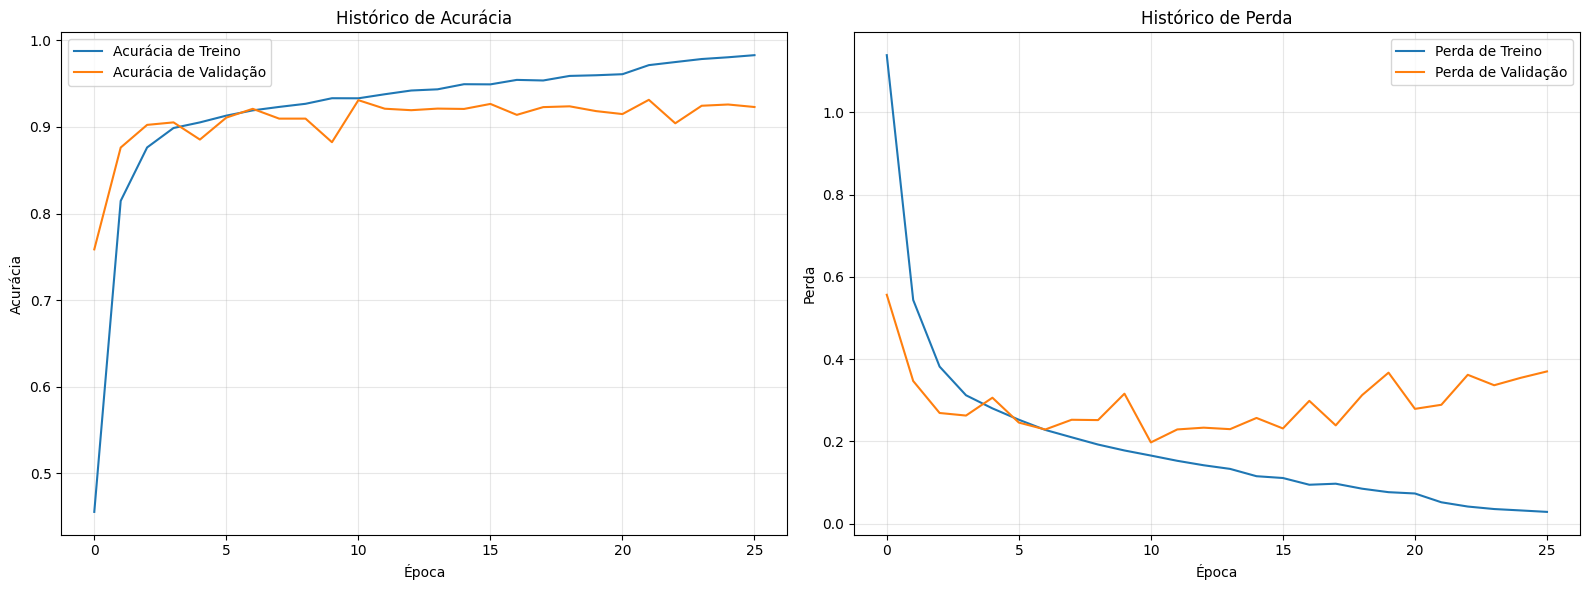


--- Relatório de Classificação Final ---
              precision    recall  f1-score   support

          AF     0.8631    0.9030    0.8826       691
           N     0.9657    0.9624    0.9640      4762
           O     0.8636    0.8535    0.8585      1536
       RUIDO     0.9595    0.9626    0.9610       615

    accuracy                         0.9350      7604
   macro avg     0.9130    0.9204    0.9166      7604
weighted avg     0.9352    0.9350    0.9351      7604


Gerando Matriz de Confusão...


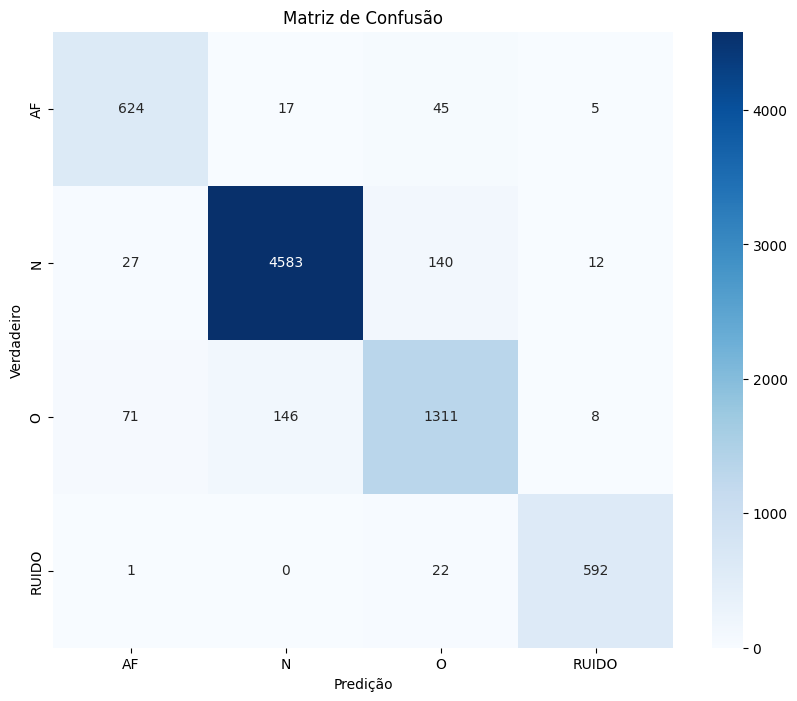


Gerando Curvas ROC...


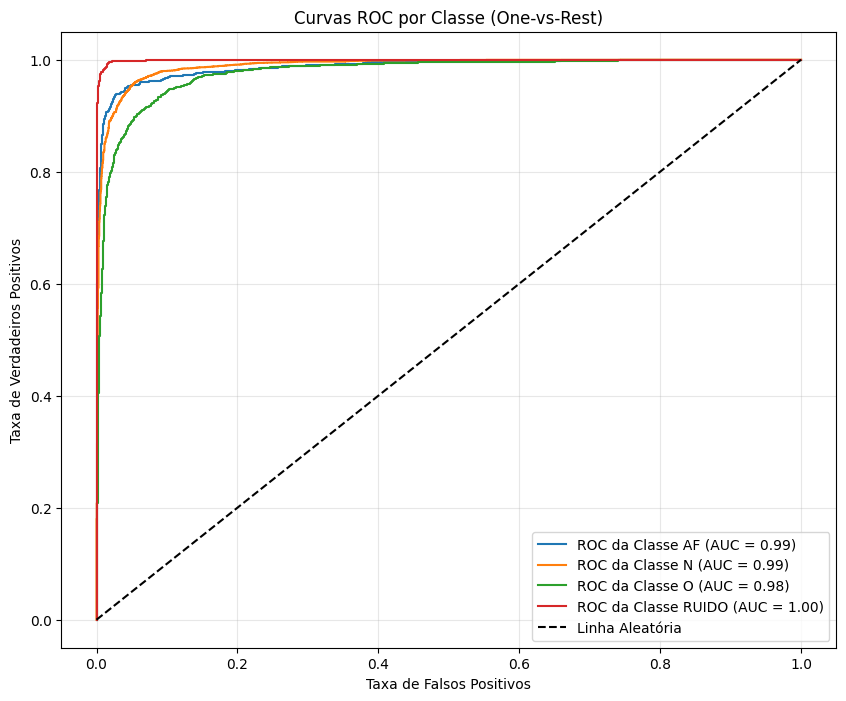


--- Etapa 6: Salvando o modelo treinado ---

✅ Modelo final salvo com sucesso em: ..\models\kb2s_plus_final_model.keras

--- Processo Completo Finalizado ---


In [39]:
# --- 1. PREPARAÇÃO DE VARIÁVEIS (os dados já estão carregados) ---
print("--- Etapa 1: Preparando variáveis para o modelo ---")
class_names = le.classes_
num_classes = len(class_names)
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"Classes: {class_names}")
print(f"Shape de entrada para o modelo: {input_shape}")


# --- 2. CONSTRUÇÃO E COMPILAÇÃO DO MODELO (com a classe corrigida) ---
print("\n--- Etapa 2: Construindo e compilando o modelo KB2S_Plus ---")
model_builder = KB2SPlusModel(input_shape=input_shape, num_classes=num_classes)
model = model_builder.build_model()
# CORREÇÃO 1: Taxa de aprendizado reduzida para maior estabilidade
model_builder.compile_model(learning_rate=0.0001)
model.summary()


# --- 3. CÁLCULO DOS PESOS DE CLASSE (com limite máximo) ---
print("\n--- Etapa 3: Calculando pesos de classe com limite ---")
# Calcula os pesos normalmente usando o scikit-learn
class_weights_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# CORREÇÃO 2: Aplica o limite máximo de 3.0 em cada peso
max_weight_cap = 3.0
capped_weights_array = [min(weight, max_weight_cap) for weight in class_weights_array]
class_weights_dict = dict(enumerate(capped_weights_array))

print(f"Pesos de classe calculados e limitados: {class_weights_dict}")


# --- 4. TREINAMENTO DO MODELO ---
print("\n--- Etapa 4: Iniciando o treinamento do modelo com parâmetros estáveis ---")
history = model_builder.train_model(
    X_train, y_train, X_val, y_val,
    epochs=100,
    batch_size=32,
    class_weights=class_weights_dict
)
print("Treinamento concluído.")


# --- 5. AVALIAÇÃO COMPLETA NO CONJUNTO DE TESTE ---
print("\n--- Etapa 5: Avaliando o modelo no conjunto de teste ---")
evaluator = MetricsEvaluator(class_names)
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Plotar Curvas de Treinamento
print("\nGerando curvas de treinamento (Acurácia e Perda)...")
evaluator.plot_training_curves(history)

# Exibir Relatório de Classificação Detalhado
print("\n--- Relatório de Classificação Final ---")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# Plotar Matriz de Confusão
print("\nGerando Matriz de Confusão...")
evaluator.plot_confusion_matrix(y_test, y_pred)

# Plotar Curvas ROC
print("\nGerando Curvas ROC...")
evaluator.plot_roc_curves(y_test, y_pred_proba)


# --- 6. SALVAR O MODELO FINAL ---
print("\n--- Etapa 6: Salvando o modelo treinado ---")
models_dir = os.path.join(base_dir, 'models')
os.makedirs(models_dir, exist_ok=True)
model_save_path = os.path.join(models_dir, 'kb2s_plus_final_model.keras')
model.save(model_save_path)
relative_path = os.path.relpath(model_save_path, start=os.getcwd())
print(f"\n✅ Modelo final salvo com sucesso em: {relative_path}")
print("\n--- Processo Completo Finalizado ---")


--- Gerando Gráfico Detalhado de Métricas por Classe ---


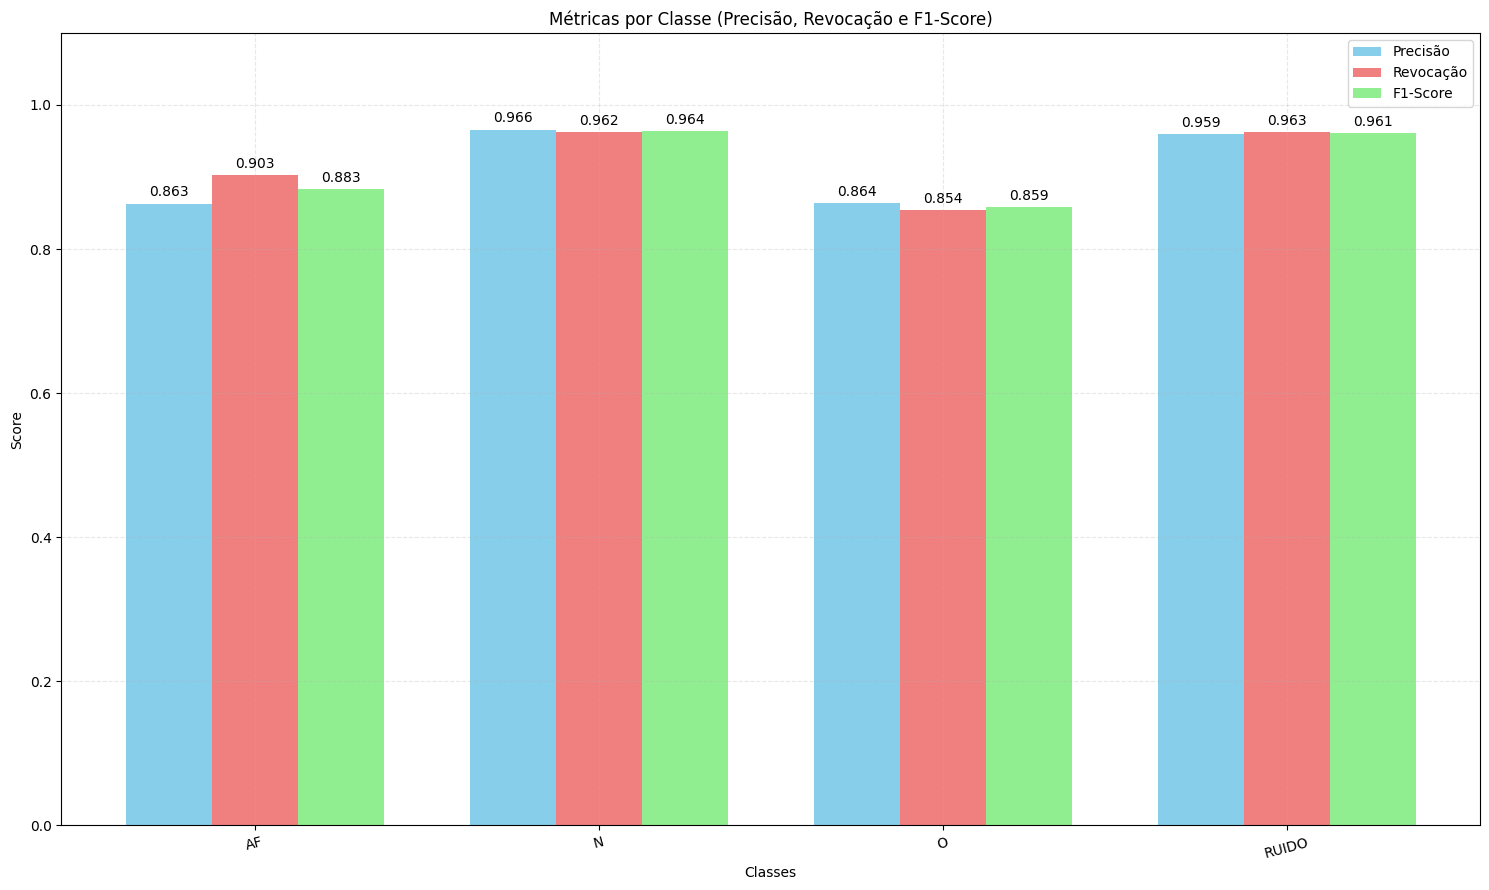

In [40]:
print("\n--- Gerando Gráfico Detalhado de Métricas por Classe ---")

# Verifica se as variáveis necessárias existem na memória
if 'y_test' not in locals() or 'y_pred' not in locals() or 'le' not in locals():
    print("ERRO: As variáveis 'y_test', 'y_pred' e 'le' (LabelEncoder) não foram encontradas.")
    print("Por favor, execute a célula de avaliação do modelo primeiro.")
else:
    # Obtém os nomes das classes do LabelEncoder
    class_names = le.classes_
    
    # Calcula as métricas por classe. average=None retorna um array com a métrica para cada classe.
    precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    # Configuração do gráfico
    x = np.arange(len(class_names))  # Posições dos rótulos no eixo x
    width = 0.25  # Largura das barras

    fig, ax = plt.subplots(figsize=(15, 9)) # Aumenta o tamanho para melhor visualização
    
    # Cria as barras para cada métrica
    bars_precision = ax.bar(x - width, precision_per_class, width, label='Precisão', color='skyblue')
    bars_recall = ax.bar(x, recall_per_class, width, label='Revocação', color='lightcoral')
    bars_f1 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='lightgreen')

    # Adiciona os valores no topo de cada barra
    ax.bar_label(bars_precision, padding=3, fmt='%.3f')
    ax.bar_label(bars_recall, padding=3, fmt='%.3f')
    ax.bar_label(bars_f1, padding=3, fmt='%.3f')

    # Configurações de rótulos, título e legenda
    ax.set_ylabel('Score')
    ax.set_xlabel('Classes')
    ax.set_title('Métricas por Classe (Precisão, Revocação e F1-Score)')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=15)
    ax.legend()
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(0, 1.1) # Define o limite do eixo y para ter um espaço extra no topo

    fig.tight_layout()
    plt.show()

In [42]:
import os
import shutil
# --- 1. Definição dos Caminhos ---

# Define o diretório base do projeto (assumindo que o notebook está em uma subpasta)
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Caminho original do modelo que foi salvo
original_model_path = os.path.join(base_dir, 'models', 'kb2s_plus_final_model.keras')

# Novo diretório de destino para organizar o modelo
new_model_dir = os.path.join(base_dir, 'models', 'modelo13_10_25')

# Caminho final completo para onde o modelo será movido
final_model_path = os.path.join(new_model_dir, 'kb2s_plus_final_model.keras')


# --- 2. Lógica para Criar a Pasta e Mover o Arquivo ---

print("Iniciando a reorganização do arquivo do modelo...")

# Cria o novo diretório de destino. O 'exist_ok=True' evita erros se a pasta já existir.
os.makedirs(new_model_dir, exist_ok=True)
print(f"Diretório de destino '{os.path.basename(new_model_dir)}' verificado/criado.")

# Verifica se o arquivo de modelo original existe antes de tentar movê-lo
if os.path.exists(original_model_path):
    # Move o arquivo para o novo local
    shutil.move(original_model_path, final_model_path)
    
    # Gera caminhos relativos para uma impressão limpa e segura
    original_rel_path = os.path.relpath(original_model_path, start=base_dir)
    final_rel_path = os.path.relpath(final_model_path, start=base_dir)
    
    print("\n Sucesso! O modelo foi movido.")
    print(f"De:   .../{original_rel_path}")
    print(f"Para: .../{final_rel_path}")

# Verifica se o arquivo JÁ foi movido em uma execução anterior
elif os.path.exists(final_model_path):
    print("\n Aviso: O modelo já está no diretório de destino. Nenhuma ação foi necessária.")

# Se não encontrar o arquivo em nenhum dos locais
else:
    original_rel_path = os.path.relpath(original_model_path, start=base_dir)
    print(f"\n Erro: O arquivo de modelo original não foi encontrado em '.../{original_rel_path}'.")
    print("Verifique se o modelo foi salvo corretamente com este nome antes de executar este script.")

Iniciando a reorganização do arquivo do modelo...
Diretório de destino 'modelo13_10_25' verificado/criado.

 Sucesso! O modelo foi movido.
De:   .../models\kb2s_plus_final_model.keras
Para: .../models\modelo13_10_25\kb2s_plus_final_model.keras


In [43]:
# --- CÉLULA PARA SALVAR APENAS OS PESOS ---

# Define o caminho para salvar o arquivo de pesos (formato .h5 é comum para isso)
pesos_save_path = os.path.join(base_dir, 'models', 'modelo13_10_25', 'kb2s_plus_trained_weights.weights.h5')

# Salva apenas os pesos do modelo que está na memória
model.save_weights(pesos_save_path)

print("✅ Pesos do modelo treinados foram salvos com sucesso!")
print(f"Arquivo de pesos salvo em: {os.path.relpath(pesos_save_path, start=os.getcwd())}")

✅ Pesos do modelo treinados foram salvos com sucesso!
Arquivo de pesos salvo em: ..\models\modelo13_10_25\kb2s_plus_trained_weights.weights.h5
